In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
import matplotlib.pyplot as plt

In [11]:
from sklearn.tree import plot_tree

In [6]:
dta = pd.read_csv('Crop_recommendation.csv', sep=';')

**Random forest sur l'ensemble des cultures :**

In [7]:
# Séparer les variables explicatives et la variable cible
X = dta.drop(columns='label')  # Toutes les colonnes sauf 'label'
y = dta['label']

# Diviser en jeu d'entraînement et de test (75%/25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Modèle Random Forest avec validation croisée à 10 folds
rf_model = RandomForestClassifier(random_state=42)
cross_val_scores = cross_val_score(rf_model, X_train, y_train, cv=10)

# Afficher la performance moyenne pendant la validation croisée
print(f"Cross-validation accuracy: {cross_val_scores.mean()}")

# Entraîner le modèle sur l'ensemble d'entraînement
rf_model.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred = rf_model.predict(X_test)

Cross-validation accuracy: 0.9951515151515151


In [8]:
# Matrice de confusion et précision (accuracy)
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"Matrice de confusion :\n{conf_matrix}")
print(f"Accuracy: {accuracy}")

Matrice de confusion :
[[29  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 23  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 31  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 27  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 23  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 27  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0 25  0  0  0  0  0  0  0  0]
 [ 0  0  0 

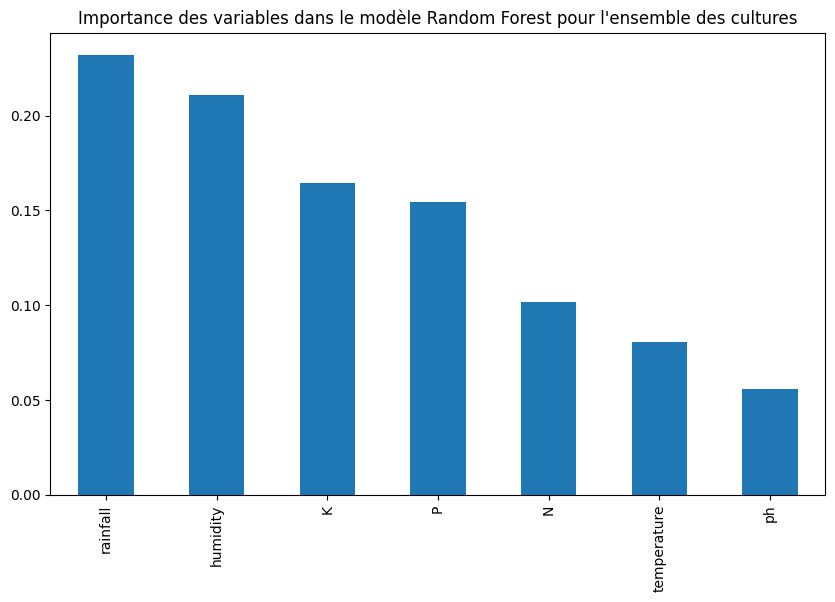

In [9]:
# Afficher l'importance des variables
importances = rf_model.feature_importances_
feature_importance = pd.Series(importances, index=X.columns)
feature_importance.sort_values(ascending=False).plot(kind='bar', figsize=(10, 6))
plt.title('Importance des variables dans le modèle Random Forest pour l\'ensemble des cultures')
plt.show()

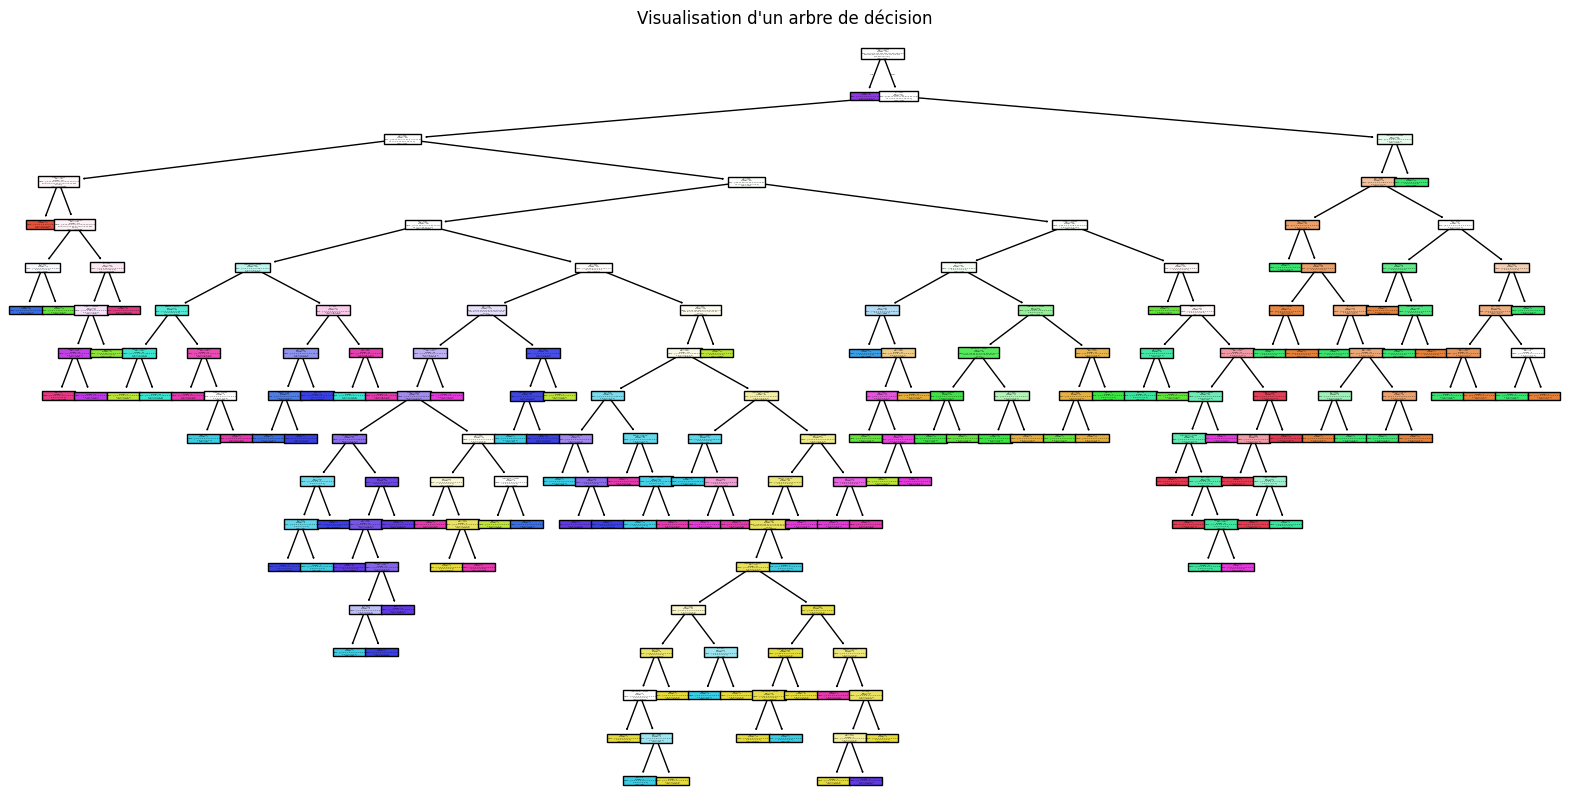

In [12]:
# Visualisation d'un arbre de décision
plt.figure(figsize=(20, 10))
plot_tree(rf_model.estimators_[0], feature_names=X.columns, class_names=rf_model.classes_, filled=True)
plt.title('Visualisation d\'un arbre de décision')
plt.show()

**Random forest sur les sous-ensembles de cultures similaires :**

In [13]:
# Filtrer les cultures similaires (Coffee, Cotton, Maize, Rice, Jute)
cultures_similaires = ['coffee', 'cotton', 'maize', 'rice', 'jute']
filtered_data = dta[dta['label'].isin(cultures_similaires)]

# Réassigner X et y pour les sous-ensembles de cultures similaires
X_filtered = filtered_data.drop(columns='label')
y_filtered = filtered_data['label']

# Diviser en jeu d'entraînement et de test (75%/25%)
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.25, random_state=42)

# Entraîner le modèle Random Forest
rf_model_similar = RandomForestClassifier(random_state=42)
rf_model_similar.fit(X_train, y_train)

# Prédictions sur l'ensemble de test filtré
y_pred_filtered = rf_model_similar.predict(X_test)

In [14]:
# Matrice de confusion et précision pour le sous-ensemble
conf_matrix_filtered = confusion_matrix(y_test, y_pred_filtered)
accuracy_filtered = accuracy_score(y_test, y_pred_filtered)

print(f"Matrice de confusion pour les cultures similaires:\n{conf_matrix_filtered}")
print(f"Accuracy pour les cultures similaires: {accuracy_filtered}")

Matrice de confusion pour les cultures similaires:
[[27  0  0  0  0]
 [ 0 17  0  0  0]
 [ 0  0 30  0  0]
 [ 0  0  0 19  0]
 [ 0  0  0  0 32]]
Accuracy pour les cultures similaires: 1.0


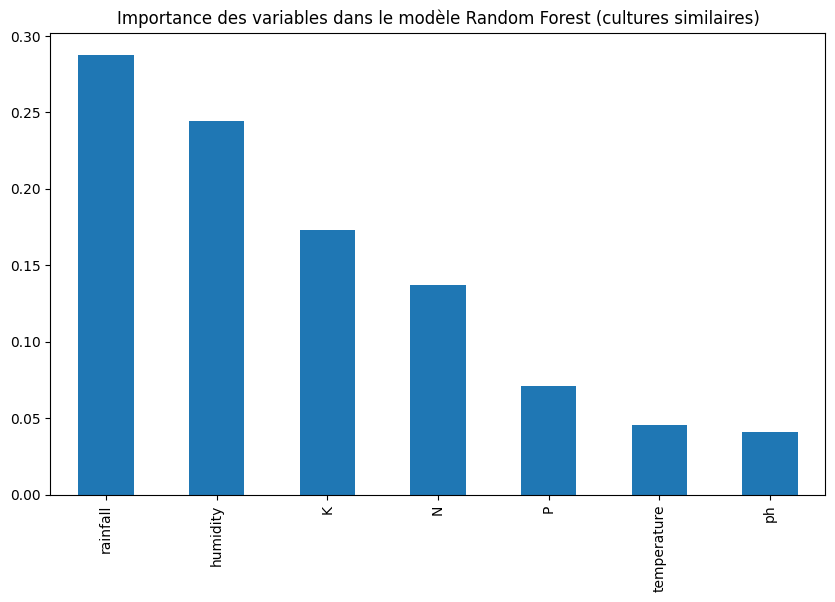

In [15]:
# Afficher l'importance des variables
importances_similar = rf_model_similar.feature_importances_
feature_importance_similar = pd.Series(importances_similar, index=X_filtered.columns)
feature_importance_similar.sort_values(ascending=False).plot(kind='bar', figsize=(10, 6))
plt.title('Importance des variables dans le modèle Random Forest (cultures similaires)')
plt.show()

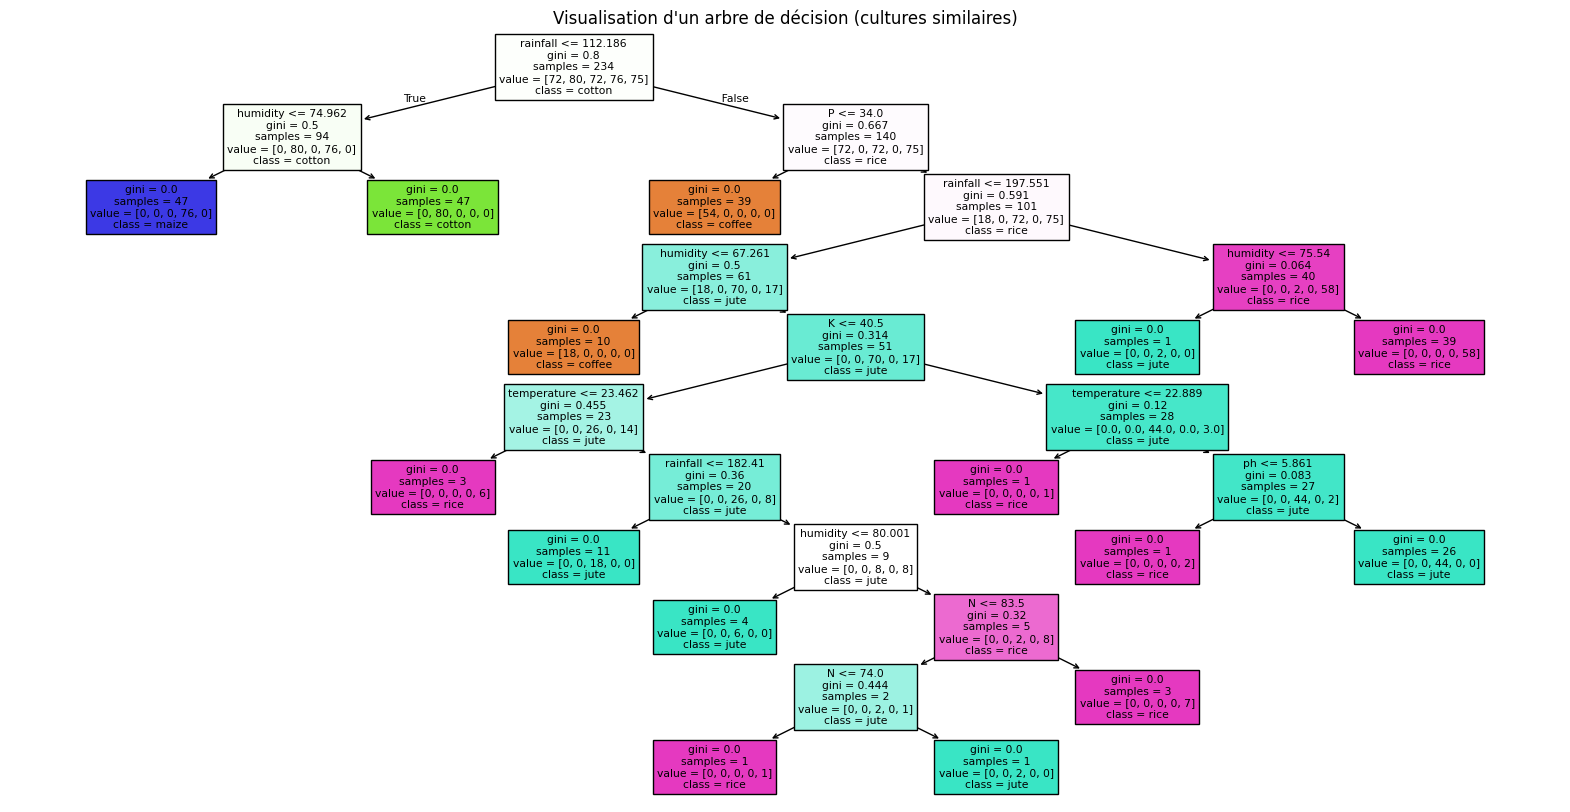

In [16]:
# Visualisation d'un arbre de décision
plt.figure(figsize=(20, 10))
plot_tree(rf_model_similar.estimators_[0], feature_names=X_filtered.columns, class_names=rf_model_similar.classes_, filled=True)
plt.title('Visualisation d\'un arbre de décision (cultures similaires)')
plt.show()

**Random forest sur les sous-ensembles de cultures différentes :**

In [17]:
# Filtrer les cultures variées (Banana, Lentil, Apple, Mango, Chickpea)
cultures_variees = ['banana', 'lentil', 'apple', 'mango', 'chickpea']
filtered_data_variees = dta[dta['label'].isin(cultures_variees)]

# Réassigner X et y pour les sous-ensembles de cultures variées
X_filtered_variees = filtered_data_variees.drop(columns='label')
y_filtered_variees = filtered_data_variees['label']

# Diviser en jeu d'entraînement et de test (75%/25%)
X_train_variees, X_test_variees, y_train_variees, y_test_variees = train_test_split(X_filtered_variees, y_filtered_variees, test_size=0.25, random_state=42)

# Entraîner le modèle Random Forest
rf_model_variees = RandomForestClassifier(random_state=42)
rf_model_variees.fit(X_train_variees, y_train_variees)

# Prédictions sur l'ensemble de test filtré
y_pred_filtered_variees = rf_model_variees.predict(X_test_variees)

In [18]:
# Matrice de confusion et précision pour le sous-ensemble
conf_matrix_filtered_variees = confusion_matrix(y_test_variees, y_pred_filtered_variees)
accuracy_filtered_variees = accuracy_score(y_test_variees, y_pred_filtered_variees)

print(f"Matrice de confusion sur les sous-ensembles de cultures différentes :\n{conf_matrix_filtered_variees}")
print(f"Accuracy des sous-ensembles de cultures différentes : {accuracy_filtered_variees}")


Matrice de confusion sur les sous-ensembles de cultures différentes :
[[27  0  0  0  0]
 [ 0 17  0  0  0]
 [ 0  0 32  0  0]
 [ 0  0  0 19  0]
 [ 0  0  0  0 30]]
Accuracy des sous-ensembles de cultures différentes : 1.0


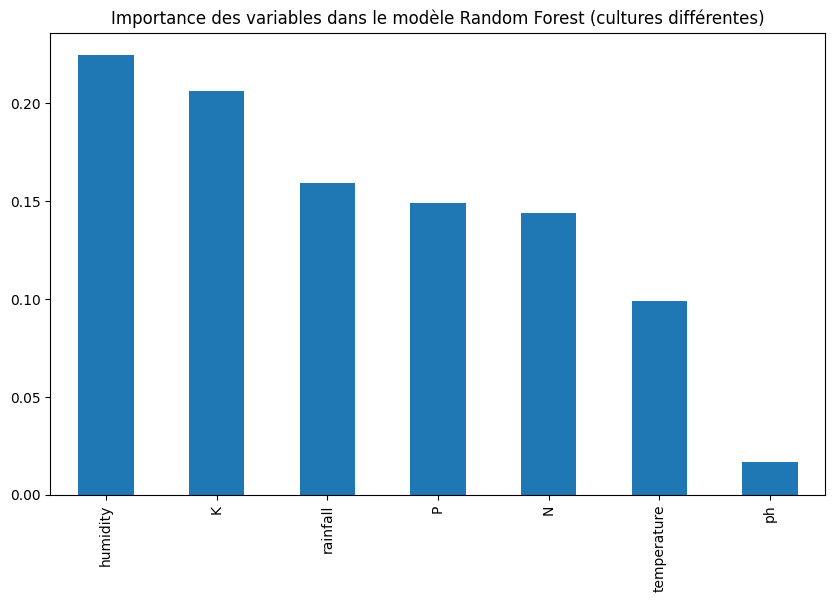

In [19]:
# Afficher l'importance des variables
importances_variees = rf_model_variees.feature_importances_
feature_importance_variees = pd.Series(importances_variees, index=X_filtered_variees.columns)
feature_importance_variees.sort_values(ascending=False).plot(kind='bar', figsize=(10, 6))
plt.title('Importance des variables dans le modèle Random Forest (cultures différentes)')
plt.show()

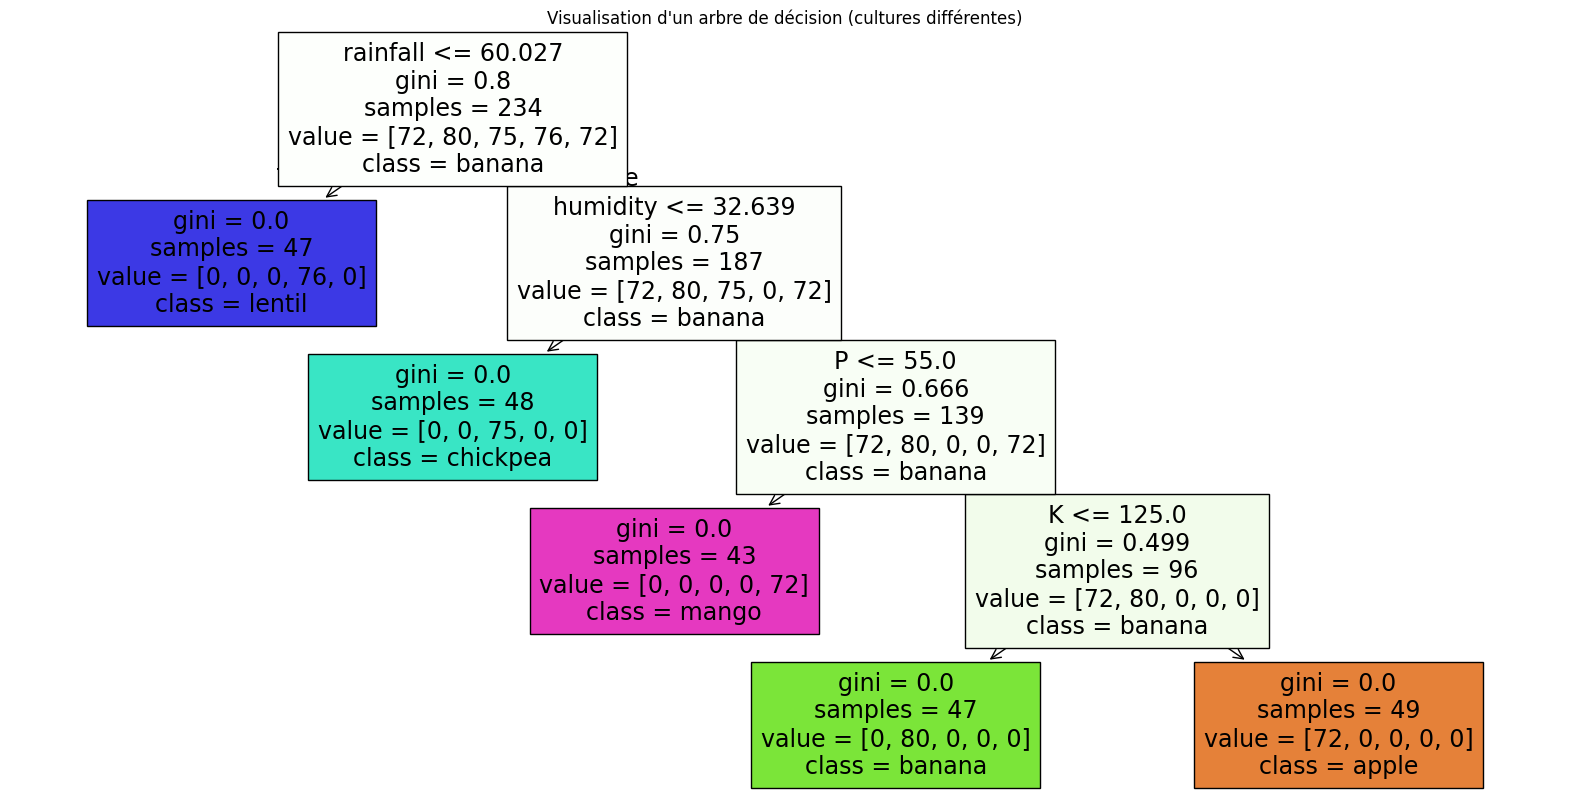

In [20]:
# Visualisation d'un arbre de décision
plt.figure(figsize=(20, 10))
plot_tree(rf_model_variees.estimators_[0],
          feature_names=X_filtered_variees.columns,
          class_names=rf_model_variees.classes_,
          filled=True)
plt.title('Visualisation d\'un arbre de décision (cultures différentes)')
plt.show()